# 18460 Project

In [88]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we initialize the task for a given configuration

In [89]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
#task = ct.CircleTask(ct.solo_config) # Circle
task = lgrt.LogisticRegressionTask() # Logistic regression with mushrooms

Intializing task LogisticRegressionTask with config Config(clients=[<Computation.HIGH: 1>], lr=0.01, nlr=0.01)


Seeing the data

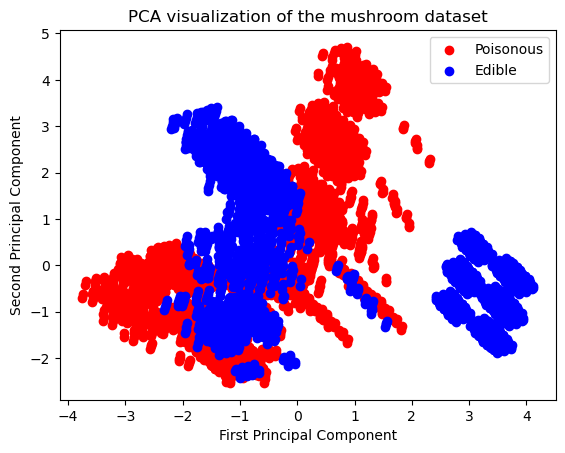

In [90]:
task.visualize()

Solve iteratively using federated learning

In [91]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(task)
server.connect_clients() # create clients with problem description including a partition of the dataset

start_time = time.perf_counter()
problem = task.get_problem()

k = 0
accuracys = []
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost

    solution = server.consensus.flatten()
    prediction = task.get_prediction(solution)
    accuracy = task.get_accuracy(prediction)
    accuracys.append(accuracy)
    
    k = k + 1
    
end_time = time.perf_counter()
if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")

print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")
print(f"Elasped time: {end_time - start_time}")
print(f"Elasped time: {end_time - start_time}")
print(f"Accuracy: {accuracy}")


        Iteration 0: [ 1.16230801  1.12446544 -1.13375623  0.53664378 -0.81276356 -0.83768241
 -1.41806039 -1.61472368 -0.92977056 -1.00658026 -0.68094654  0.43688132
 -0.1768052  -2.63865941 -1.76705171  0.23376253 -0.87489487  0.36043702
 -0.04556186 -1.65732308  0.08668493 -0.64865989 -1.04461068]
        Cost: 22787.778652288896

        

        Iteration 500: [ 0.05597964  0.6683163  -0.29862154 -0.79037016 -0.6525719   0.06337082
 -2.00008605  2.29200774 -0.53281873 -1.09954204 -1.37390639 -1.16338156
 -0.46728848 -0.69310857 -0.4314408   0.23376253  0.79338909 -0.09113207
  0.45473109 -1.44392648  0.12645356  0.12452497 -0.26883492]
        Cost: 1825.4877180245994

        

        Iteration 1000: [-0.06013101  0.70036869 -0.10697421 -0.66938352 -0.84956478 -0.42846941
 -1.96272042  2.80956528 -0.40661467 -0.51783613 -1.52474748 -1.53435157
 -0.45721501 -0.48539741 -0.26824376  0.23376253  1.49846854  0.22899993
  0.83015024 -1.11314614 -0.08038734  0.1024942  -0.30609853]



        Iteration 12000: [-2.16642451e-02  5.58660050e-01 -1.60226206e-01 -3.21661622e-01
 -1.59446012e+00 -2.25810296e+00 -3.81118629e+00  4.85367754e+00
 -5.03415421e-01  4.97202992e-01 -2.76128029e+00 -4.20980079e+00
 -3.24238545e-04 -3.00882958e-01 -1.04843238e-01  2.33762535e-01
  4.93771732e+00  8.42418398e-01  2.82576835e+00 -7.36670348e-01
 -9.61548928e-01  3.95003271e-02 -6.02068756e-01]
        Cost: 1315.9957442785

        
Condition reached: change in cost is 8.81820824361057e-07 which is smaller than 1e-06

Solution: [-0.02090842  0.55811925 -0.16185331 -0.30987656 -1.6066909  -2.2860261
 -3.85238629  4.89799948 -0.50550463  0.4915135  -2.81162396 -4.25079957
  0.0054842  -0.30222903 -0.10526717  0.23376253  4.99998193  0.84358184
  2.87248808 -0.73377587 -0.96934389  0.04056502 -0.62119624]
Associated cost: 1315.975068681401
Achieved in 12350 iterations
Elasped time: 71.47804840700701
Elasped time: 71.47804840700701
Accuracy: 0.9521171836533727


## Visualization of the solution

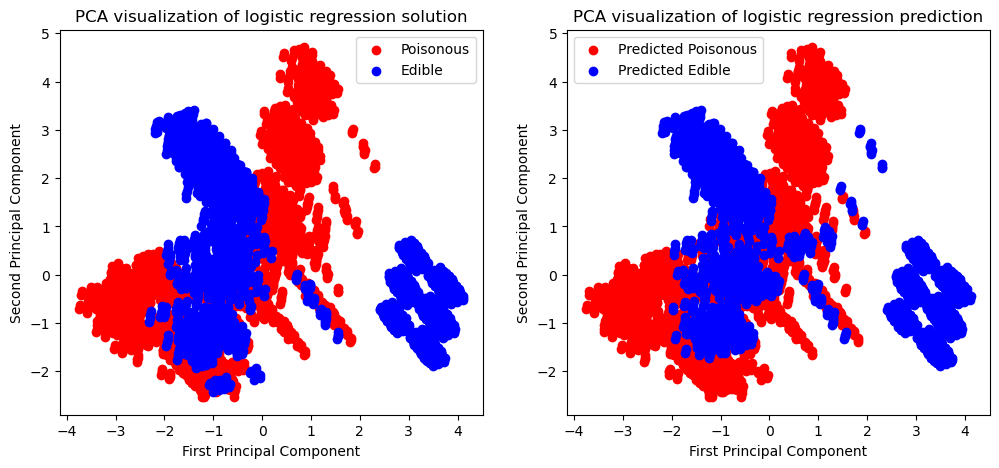

In [92]:
task.visualize_solution(solution)

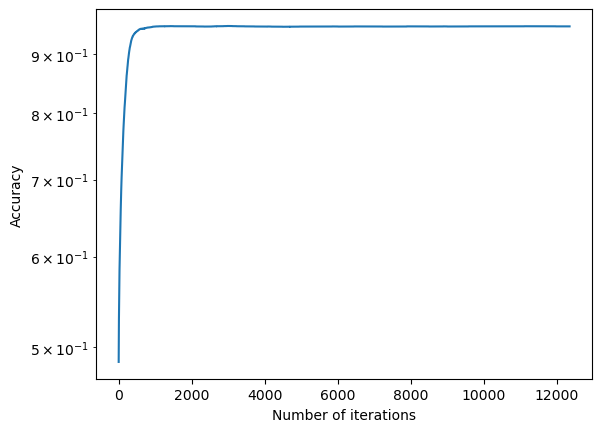

In [93]:
plt.plot(range(1, k+1), accuracys)
plt.yscale("log")
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.show()